In [1]:
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import optimize
import scipy.optimize
from scipy.optimize import minimize
from scipy.special import jv
from scipy.constants import * 
#from scipy.ndimage import gaussian_filter1d
import sys

import matplotlib.colors as mcolors
from mpl_toolkits.axes_grid1 import make_axes_locatable

import qgm
from qgm import image, parameter, filter, data, fitting, function

from regions import PixCoord, RectanglePixelRegion, CirclePixelRegion

cmap = image.generate_cmap(['#330000', 'r', 'w'])

# 2023/02/14 Data004, Scan004
## Spiral2, Shaking #2 and #3, TOF

In [2]:
date = '20230214'
dataNo = 4
scanNo = 4

In [3]:
def create_scan_and_image_data(date,dataNo,scanNo):
    path = r"./"+date
    path_img = path + r"/data" + str('%03d' % dataNo) + "/raw"
    path_scan = path + r"/scandir/Scan" + str('%03d' % scanNo) + '.txt'
    path_param = path + r"/scandir/Parameters" + str('%03d' % scanNo) + '.txt'
    scan_data = pd.read_csv(path_scan, delimiter='\t')
    param_name ='A0143: LS amplitude (y) 1'
    scan_param =scan_data[param_name]
    unique_param = np.sort(scan_param.unique())
    flcount = scan_data['Total count1 @ ROI1 (arb. u.)']
    share = Path(path_img)
    if share.exists():
        trans_files = list(Path(path_img).glob('seq*_trans001.tiff'))
        flat_files = list(Path(path_img).glob('seq*_flat001.tiff'))
        update_files = list(Path(path_img).glob('seq*_update001.tiff'))
    else:
        print('No images')

    img_flat_ave =[]
    img_trans_ave = []
    img_trans_list = []
    for N in range(len(trans_files)):
        img_flat_ave += [np.array(Image.open(flat_files[N]))]
        img_trans_ave += [np.array(Image.open(trans_files[N]))]
    img_flat_ave = np.average(img_flat_ave,axis=0)
    img_trans_ave =np.average(img_trans_ave,axis=0) -img_flat_ave
    for N in range(len(trans_files)):
        img_trans_list += [np.array(Image.open(trans_files[N])) - img_flat_ave]
    return img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name

img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name = create_scan_and_image_data(date,dataNo,scanNo)

In [4]:
img_trans_list_by_unique_param = []
img_trans_ave_list_by_unique_param = []
for i in range(len(unique_param)):
    img_trans_list_tmp = []
    for j in range(len(img_trans_list)):
        if unique_param[i] == scan_param[j]:
            img_trans_list_tmp.append(img_trans_list[j])
    img_trans_list_by_unique_param.append(img_trans_list_tmp)
    img_trans_ave_list_by_unique_param.append(np.average(img_trans_list_tmp,axis=0))

In [5]:
lambda_L=1064*10**(-9) #[m]QMBD
h_bar = h/(2*np.pi) #Converted Plank constant
mrb = 87*10**(-3)/N_A #[kg] atom mass of 87Rb
a = 2/3*lambda_L
Omega = 2*np.pi*1.2*1e3 #[Hz] Shaking frequency

In [6]:
controlVoltageToAM_x = -8 #[V] control voltage from NI-DAQ to WF1968 mod. in via buffer amp
controlVoltageToAM_y = unique_param
modulationSignalVpp = 5.0 #[V] Amplitude of modulation singal
bufferAmpForAM = 1/8 # gain of buffer amp for modulatin sinal
coeffInPM = 130

In [7]:
def calculate_forcing_amplitude(controlVoltageToAM_x, controlVoltageToAM_y, modulationSignalVpp, bufferAmpForAM, coeffInPM):
    phaseModAmplitude_x = (controlVoltageToAM_x*bufferAmpForAM+1)/2*modulationSignalVpp/2*coeffInPM #[degree]
    phaseModAmplitude_y = (controlVoltageToAM_y*bufferAmpForAM+1)/2*modulationSignalVpp/2*coeffInPM #[degree]
    dx = phaseModAmplitude_x/360*a
    dy = phaseModAmplitude_y/360*a
    k=mrb*a*Omega/h_bar*dy
    kp = mrb*a*Omega/(2*h_bar)*np.sqrt(9*dx**2+dy**2)
    j = jv(0,k)
    jp = jv(0,kp)
    return j, jp

jeff_list, jpeff_list = calculate_forcing_amplitude(controlVoltageToAM_x, controlVoltageToAM_y, modulationSignalVpp, bufferAmpForAM, coeffInPM)
period_of_dw = np.pi/(2*np.arccos(-jpeff_list/(2*jeff_list)))

In [8]:
x_list = np.arange(-np.shape(img_trans_ave)[0]/2,np.shape(img_trans_ave)[0]/2)
y_list = np.arange(-np.shape(img_trans_ave)[1]/2,np.shape(img_trans_ave)[1]/2)
x_mesh, y_mesh = np.meshgrid(x_list, y_list)

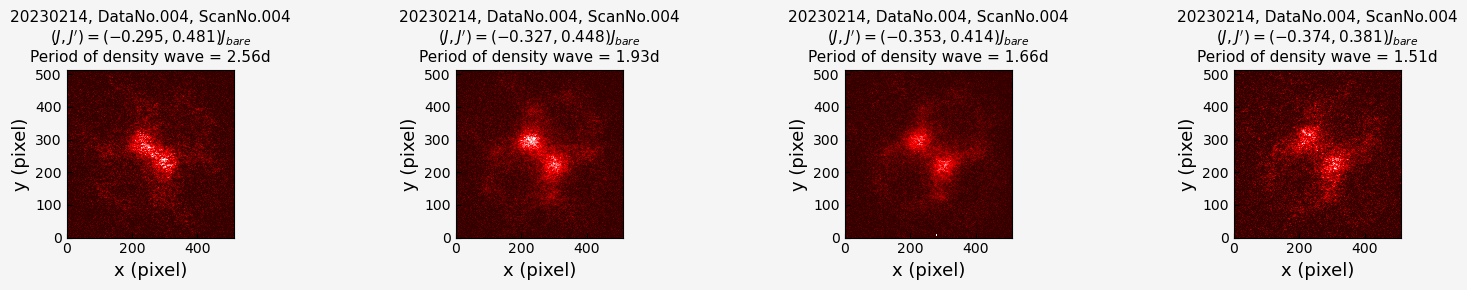

In [9]:
column_number = 4
row_number = 1

fig, axes = plt.subplots(row_number, column_number, figsize=(4*column_number,3*row_number), facecolor="whitesmoke",dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axes = np.reshape(axes, axes.size)
TOF_title_label_list = []
for n, (ax, img_) in enumerate(zip(axes, img_trans_ave_list_by_unique_param)):
    title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)+'\n'+r'$(J,J^{\prime})=(%.03f,%.03f)J_{bare}$'%(jeff_list[n],jpeff_list[n])+'\n'+'Period of density wave = %.02fd'%(period_of_dw[n])
    vmax = 0.8*np.max(img_)
    vmin = 0
    ax.pcolormesh(img_, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    ax.set_aspect('equal')
    ax.tick_params(axis='both',direction='in')
    ax.set_xlabel('x (pixel)',fontsize=13)
    ax.set_ylabel('y (pixel)',fontsize=13)
    ax.set_title(title_label,fontsize=11)
    TOF_title_label_list.append(title_label)
plt.tight_layout()
plt.show()

In [10]:
averaged_TOF_image_list = img_trans_ave_list_by_unique_param

# 2023/02/15 Data002, Scan002
## Spiral2, Shaking #2 and #3, In-situ

In [11]:
date = '20230215'
dataNo = 2
scanNo = 2
img_trans_list, img_trans_ave, scan_param, unique_param, flcount, unit, param_name = create_scan_and_image_data(date,dataNo,scanNo)
img_trans_list_by_unique_param = []
img_trans_ave_list_by_unique_param = []
for i in range(len(unique_param)):
    img_trans_list_tmp = []
    for j in range(len(img_trans_list)):
        if unique_param[i] == scan_param[j]:
            img_trans_list_tmp.append(img_trans_list[j])
    img_trans_list_by_unique_param.append(img_trans_list_tmp)
    img_trans_ave_list_by_unique_param.append(np.average(img_trans_list_tmp,axis=0))
img_trans_ave = img_trans_ave_list_by_unique_param
controlVoltageToAM_y = unique_param
jeff_list, jpeff_list = calculate_forcing_amplitude(controlVoltageToAM_x, controlVoltageToAM_y, modulationSignalVpp, bufferAmpForAM, coeffInPM)
period_of_dw = np.pi/(2*np.arccos(-jpeff_list/(2*jeff_list)))

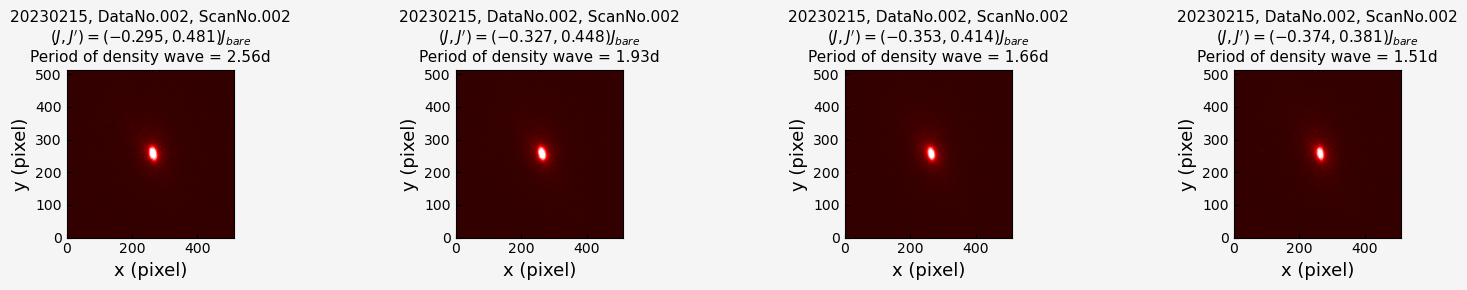

In [31]:
column_number = 4
row_number = 1

fig, axes = plt.subplots(row_number, column_number, figsize=(4*column_number,3*row_number), facecolor="whitesmoke",dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axes = np.reshape(axes, axes.size)
Insitu_title_label_list = []
for n, (ax, img_) in enumerate(zip(axes, img_trans_ave_list_by_unique_param)):
    title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)+'\n'+r'$(J,J^{\prime})=(%.03f,%.03f)J_{bare}$'%(jeff_list[n],jpeff_list[n])+'\n'+'Period of density wave = %.02fd'%(period_of_dw[n])
    title_label_tmp = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)
    vmax = 0.8*np.max(img_)
    vmin = 0
    ax.pcolormesh(img_, cmap=cmap, vmin=vmin, vmax=vmax, shading='auto')
    ax.set_aspect('equal')
    ax.tick_params(axis='both',direction='in')
    ax.set_xlabel('x (pixel)',fontsize=13)
    ax.set_ylabel('y (pixel)',fontsize=13)
    ax.set_title(title_label,fontsize=11)
    Insitu_title_label_list.append(title_label_tmp)
plt.tight_layout()
plt.show()

In [13]:
#フーリエ変換
def FFT(img):
    #フーリエ変換
    fimg = np.fft.fft2(img)
    fimg = np.fft.fftshift(fimg) #低周波成分を中央に寄せる
    #符号を保ったまま対数処理
    real = fimg.real
    real[real>0] = np.log10(real[real>0])
    real[real<0] = -np.log10(-real[real<0])
    imag = fimg.imag
    imag[imag>0] = np.log10(imag[imag>0])
    imag[imag<0] = -np.log10(-imag[imag<0])
    return real, imag

#逆フーリエ変換
def IFFT(real, imag):
    #符号を保ったまま指数処理
    real[real>0] = 10**real[real>0]
    real[real<0] = -10**(-real[real<0])
    imag[imag>0] = 10**imag[imag>0]
    imag[imag<0] = -10**(-imag[imag<0])
    #複素数行列
    fimg = np.zeros(real.shape, np.complex128)
    fimg.real = real
    fimg.imag = imag
    #逆フーリエ変換
    fimg = np.fft.ifftshift(fimg)
    img = np.fft.ifft2(fimg)
    img = img.real
    img = img.clip(0, 255).astype(np.uint8)
    return img

In [21]:
xmin_FFT = 0
xmax_FFT = np.shape(img_trans_ave[0])[0]-0
ymin_FFT = 0
ymax_FFT = np.shape(img_trans_ave[0])[1]-0
xcenter_FFT = (xmax_FFT-xmin_FFT)/2
ycenter_FFT = (ymax_FFT-ymin_FFT)/2
side = 60

In [22]:
def create_fft_image(img_trans_list):
    fft_img_list = []
    for i in range(len(img_trans_list)):
        img_tmp = img_trans_list[i]
        img_tmp = img_tmp[xmin_FFT:xmax_FFT,ymin_FFT:ymax_FFT]
        real, imag = FFT(img_tmp)
        fimg = np.zeros(real.shape, np.complex128)
        fimg.real = real
        fimg.imag = imag
        img = np.abs(fimg)
        fft_img_list.append(img)
    return fft_img_list

fft_img_list = create_fft_image(img_trans_list)

In [23]:
fft_img_list_by_unique_param = []
fft_img_ave_list_by_unique_param = []
for i in range(len(unique_param)):
    fft_img_tmp = []
    for j in range(len(fft_img_list)):
        if unique_param[i] == scan_param[j]:
            fft_img_tmp.append(fft_img_list[j])
    fft_img_list_by_unique_param.append(fft_img_tmp)
    fft_img_ave_list_by_unique_param.append(np.average(fft_img_tmp,axis=0))


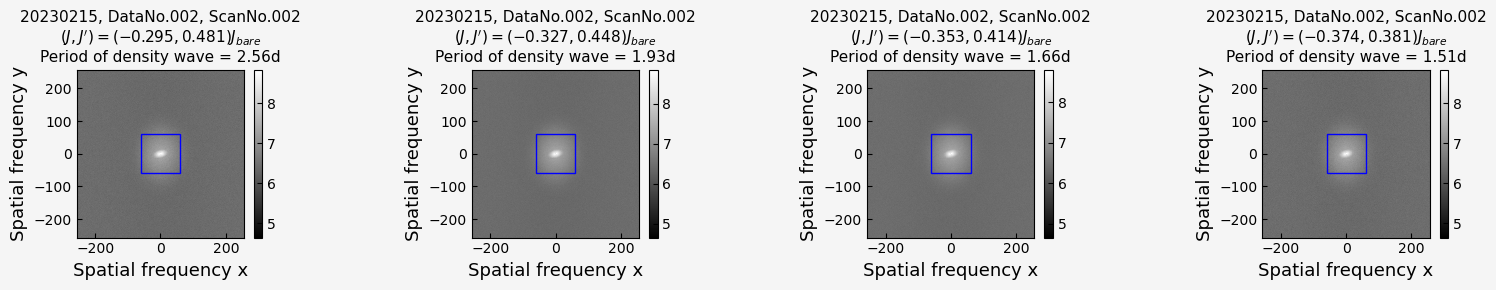

In [24]:
column_number = 4
row_number = 1

fig, axes = plt.subplots(row_number, column_number, figsize=(4*column_number,3*row_number), facecolor="whitesmoke",dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axes = np.reshape(axes, axes.size)
Insitu_title_label_list = []
for n, (ax, img_) in enumerate(zip(axes, fft_img_ave_list_by_unique_param)):
    title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)+'\n'+r'$(J,J^{\prime})=(%.03f,%.03f)J_{bare}$'%(jeff_list[n],jpeff_list[n])+'\n'+'Period of density wave = %.02fd'%(period_of_dw[n])
    vmax = np.max(img_)
    vmin = np.min(img_)
    mappable = ax.pcolormesh(x_mesh[xmin_FFT:xmax_FFT,ymin_FFT:ymax_FFT],y_mesh[xmin_FFT:xmax_FFT,ymin_FFT:ymax_FFT],img_,vmin=vmin, vmax=vmax,cmap="gray",label=title_label)
    ax.set_aspect('equal')
    ax.set_ylabel("Spatial frequency y",fontsize=13)
    ax.set_xlabel("Spatial frequency x",fontsize=13)
    ax.set_title(title_label,fontsize=11)
    ax.tick_params(axis='both',direction='in')
    divider1 = make_axes_locatable(ax)
    ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
    pp=fig.colorbar(mappable,cax=ax_cb1)
    ax_cb1.tick_params(axis='y',direction='in')
    region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
    region.plot(ax=ax, color='blue', lw=1, linestyle = '-')
plt.tight_layout()
plt.show()

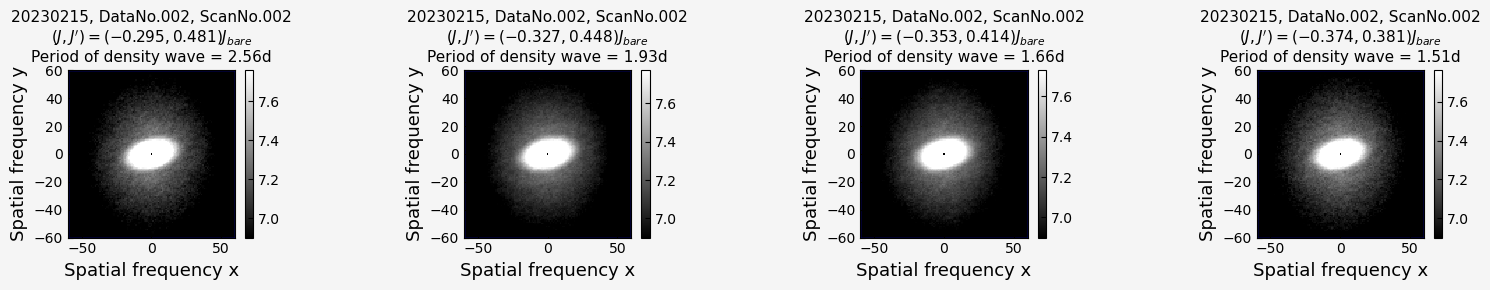

In [27]:
column_number = 4
row_number = 1

fig, axes = plt.subplots(row_number, column_number, figsize=(4*column_number,3*row_number), facecolor="whitesmoke",dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

axes = np.reshape(axes, axes.size)
Insitu_title_label_list = []
for n, (ax, img_) in enumerate(zip(axes, fft_img_ave_list_by_unique_param)):
    title_label = date+', DataNo.%03d, ScanNo.%03d'%(dataNo,scanNo)+'\n'+r'$(J,J^{\prime})=(%.03f,%.03f)J_{bare}$'%(jeff_list[n],jpeff_list[n])+'\n'+'Period of density wave = %.02fd'%(period_of_dw[n])
    vmax = 0.88*np.max(img_)
    vmin = 6.9
    mappable = ax.pcolormesh(x_mesh[xmin_FFT:xmax_FFT,ymin_FFT:ymax_FFT],y_mesh[xmin_FFT:xmax_FFT,ymin_FFT:ymax_FFT],img_,vmin=vmin, vmax=vmax,cmap="gray",label=title_label)
    ax.set_aspect('equal')
    ax.set_xlim(-side,side)
    ax.set_ylim(-side,side)
    ax.set_ylabel("Spatial frequency y",fontsize=13)
    ax.set_xlabel("Spatial frequency x",fontsize=13)
    ax.set_title(title_label,fontsize=11)
    ax.tick_params(axis='both',direction='in')
    divider1 = make_axes_locatable(ax)
    ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
    pp=fig.colorbar(mappable,cax=ax_cb1)
    ax_cb1.tick_params(axis='y',direction='in')
    region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
    region.plot(ax=ax, color='blue', lw=1, linestyle = '-')
plt.tight_layout()
plt.show()

In [28]:
averaged_Insitu_image_list = img_trans_ave_list_by_unique_param
averaged_FFT_image_list = fft_img_ave_list_by_unique_param

# Summary

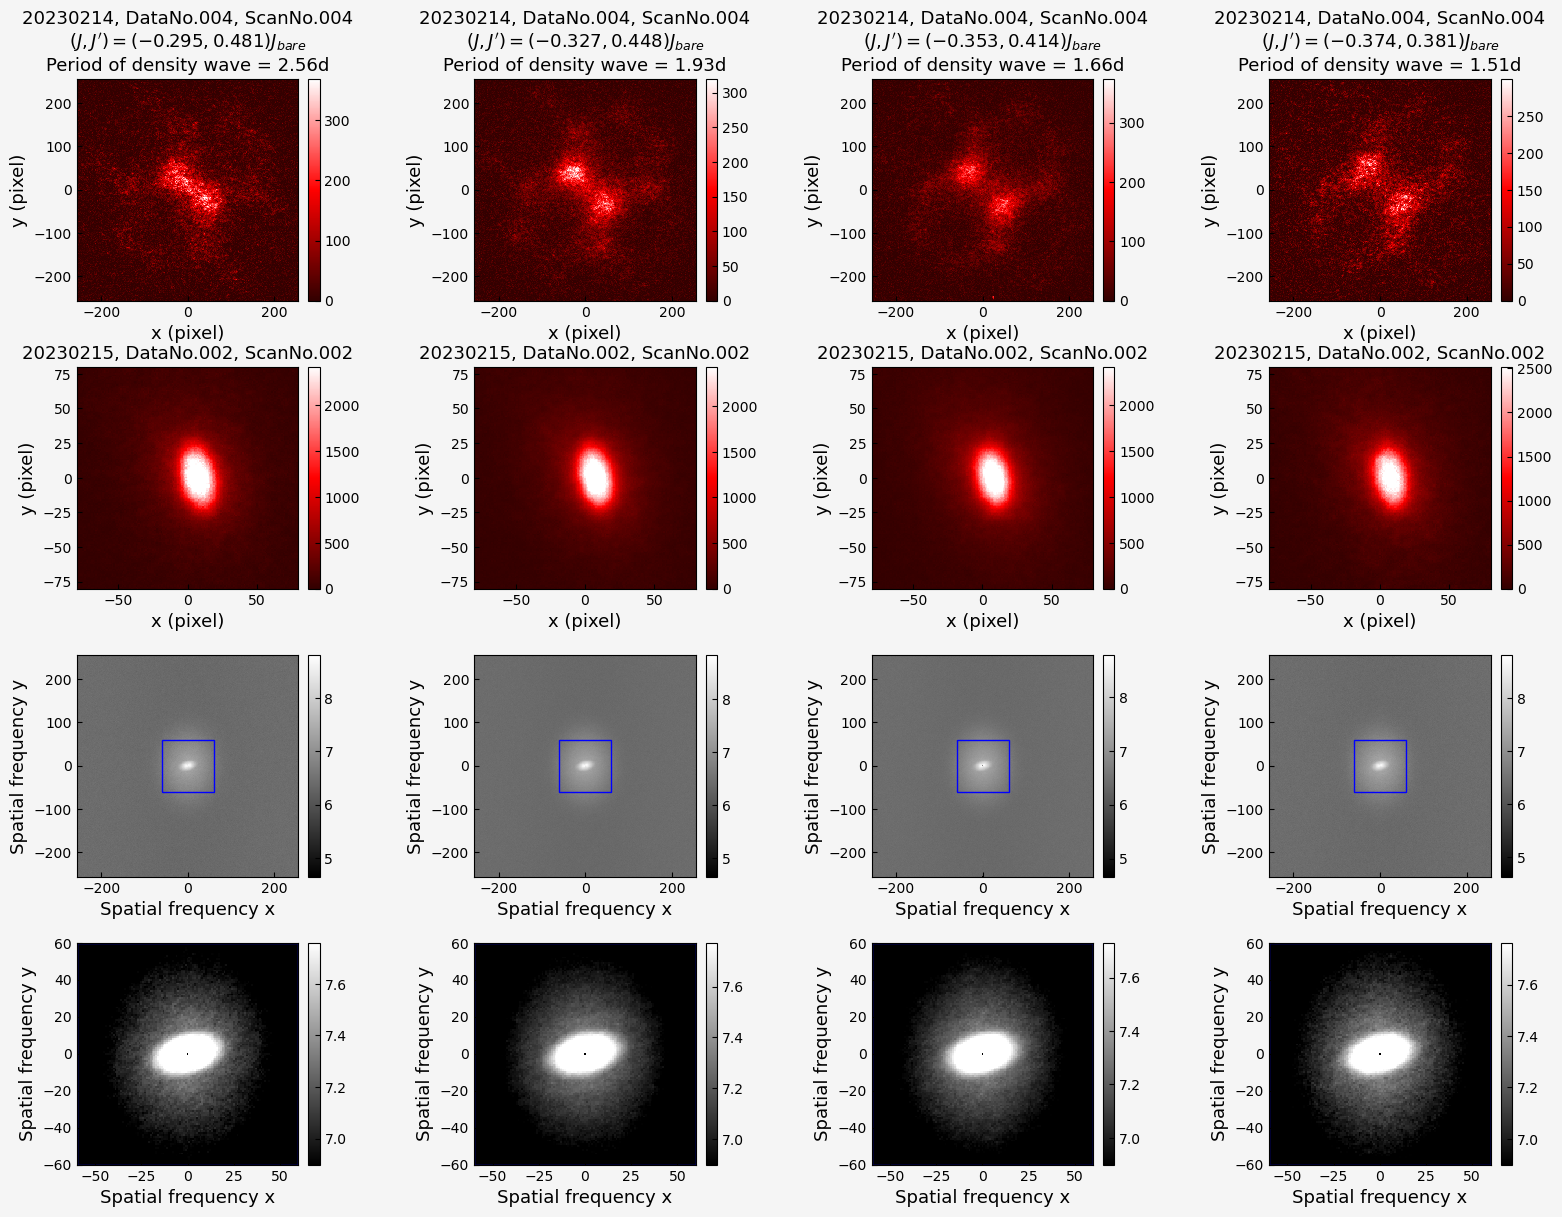

In [34]:
column_number=4
row_number=4

fig, axes = plt.subplots(row_number, column_number, figsize=(4*column_number,3*row_number), facecolor="whitesmoke",dpi=100)
plt.subplots_adjust(wspace=0.1, hspace=0.1)
for i in range(column_number):
    for j in range(row_number):
        if j == 0:
            img_ave_tmp = averaged_TOF_image_list[i]
            vmax = 0.8*np.max(img_ave_tmp)
            mappable = axes[j,i].pcolormesh(x_mesh,y_mesh,img_ave_tmp,cmap=cmap,vmin=0,vmax=vmax,shading='auto')
            axes[j,i].set_aspect('equal')
            axes[j,i].set_xlabel('x (pixel)',fontsize=13)
            axes[j,i].set_ylabel('y (pixel)',fontsize=13)
            axes[j,i].tick_params(axis='both',direction='in')
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            ax_cb1.tick_params(axis='y',direction='in')
            axes[j,i].set_title(TOF_title_label_list[i],fontsize=13)
        elif j == 1:
            img_ave_tmp = averaged_Insitu_image_list[i]
            vmax = 0.8*np.max(img_ave_tmp)
            mappable = axes[j,i].pcolormesh(x_mesh,y_mesh,img_ave_tmp,cmap=cmap,vmin=0,vmax=vmax,shading='auto')
            axes[j,i].set_aspect('equal')
            axes[j,i].set_xlim(-80,80)
            axes[j,i].set_ylim(-80,80)
            axes[j,i].set_xlabel('x (pixel)',fontsize=13)
            axes[j,i].set_ylabel('y (pixel)',fontsize=13)
            axes[j,i].tick_params(axis='both',direction='in')
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            ax_cb1.tick_params(axis='y',direction='in')
            axes[j,i].set_title(Insitu_title_label_list[i],fontsize=13)
        elif j == 2:
            fft_img_ave = averaged_FFT_image_list[i]
            vmax = np.max(fft_img_ave)
            vmin = np.min(fft_img_ave)
            mappable=axes[j,i].pcolormesh(x_mesh,y_mesh,fft_img_ave,vmin=vmin, vmax=vmax,shading='auto',cmap="gray")
            axes[j,i].set_aspect('equal')
            axes[j,i].set_ylabel("Spatial frequency y",fontsize=13)
            axes[j,i].set_xlabel("Spatial frequency x",fontsize=13)
            axes[j,i].tick_params(axis='both',direction='in')
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            ax_cb1.tick_params(axis='y',direction='in')
            region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
            region.plot(ax=axes[j,i], color='blue', lw=1, linestyle = '-')
        elif j == 3:
            fft_img_ave = averaged_FFT_image_list[i]
            vmax = 0.88*np.max(fft_img_ave)
            vmin = 6.9
            mappable = axes[j,i].pcolormesh(x_mesh,y_mesh,fft_img_ave,vmin=vmin,vmax=vmax,shading='auto',cmap='gray')
            axes[j,i].set_xlim(-side,side)
            axes[j,i].set_ylim(-side,side)
            axes[j,i].set_aspect('equal')
            axes[j,i].set_ylabel("Spatial frequency y",fontsize=13)
            axes[j,i].set_xlabel("Spatial frequency x",fontsize=13)
            axes[j,i].tick_params(axis='both',direction='in')
            divider1 = make_axes_locatable(axes[j,i])
            ax_cb1 = divider1.append_axes("right",size="5%",pad=0.1)
            pp=fig.colorbar(mappable,cax=ax_cb1)
            ax_cb1.tick_params(axis='y',direction='in')
            region = RectanglePixelRegion(center=PixCoord(x=0, y=0), width=2*side,height=2*side)
            region.plot(ax=axes[j,i], color='blue', lw=1, linestyle = '-')
plt.tight_layout(pad=0.1)